# Рынок заведений общественного питания Москвы

1. [Описание задачи](#task)
2. [Открытие данных](#start)
3. [Предобработка данных](#preprocessing)
     * [Форматирование](#formatting)
     * [Поиск и обработка дубликатов](#duplicates)
    
4. [Анализ данных](#data_analysis)
    * [Соотношение видов объектов общественного питания по количеству](#ratio_types)
    * [Соотношение сетевых и несетевых заведений по количеству](#ratio_chain)
    * [Анализ сетевых заведений](#chain)
    * [Среднее количество посадочных мест ](#median_number)
    * [Выделение в отдельный столбец информации об улице](#street)
    * [Топ-10 улиц по количеству объектов общественного питания](#top10)
    * [Число улиц с одним объектом общественного питания](#only_one)
    * [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания](#seats)
5. [Выводы](#summary)
6. [Рекомендации](#recommendation)
7. [Презентация](#presentation)

### 1. Описание задачи <a id="task"></a>

#### Необходимо исследовать рынок заведений общественного питания в Москве для оценки перспективы развития нашего кафе, особенностью которого является обслуживание роботами-официантами. Заказчики данного проекта - потенциальные инвесторы.


### 2. Открытие данных <a id="start"></a>

In [79]:
#Импортируем библиотеки, которые будем использовать в работе
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import re
from io import BytesIO
import requests

In [80]:
#Загрузим и изучим данные
cafe=pd.read_csv('/datasets/rest_data.csv')
cafe.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [81]:
cafe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


**<font color="purple">Пропуски данных отсутствуют, с типами данных все в порядке. Необходимо привести все текстовые данные к нижнему регистру и удалить дубликаты</font>**


### 3.Предобработка данных <a id="preprocessing"></a>

#### Форматирование <a id="formatting"></a>

In [82]:
#Приведем к нижнему регистру данные в двух столбцах
cafe['object_name'] = cafe['object_name'].str.lower()

In [83]:
cafe['address'] = cafe['address'].str.lower()

In [84]:
#Проверим уникальные значения в двух оставшихся столбцах с текстовыми данными.
cafe['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

In [85]:
cafe['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

In [86]:
#Посмотрим, как выглядит таблица теперь
cafe.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


#### Поиск и обработка дубликатов <a id="duplicates"></a>

In [87]:
#Посмотрим, есть ли дублирующие целые строки в нашем датафрейме
cafe.duplicated().sum()

0

Дубликаты целых строк отсутствуют.

За дубликаты в нашем проекте примем также заведения с одинаковым названием, адресом и типом заведения.

In [88]:
#Определим количество таких дубликатов
cafe[['object_name', 'object_type', 'address']].duplicated().sum()

184

In [89]:
#Посмотрим на них
cafe[['object_name', 'object_type', 'address']].loc[
    cafe[['object_name', 'object_type', 'address']].duplicated(), :].tail()

,object_name,object_type,address
15173,кофе с собой,предприятие быстрого обслуживания,"город москва, алтуфьевское шоссе, дом 70, корпус 1"
15216,макдоналдс,предприятие быстрого обслуживания,"город москва, варшавское шоссе, дом 87б"
15217,макдоналдс,предприятие быстрого обслуживания,"город москва, кировоградская улица, дом 13а"
15363,шоколадница,кафе,"город москва, улица земляной вал, дом 33"
15365,шоколадница,кафе,"город москва, ходынский бульвар, дом 4"


In [90]:
#Удалим дубликаты
cafe = cafe.drop_duplicates(subset=['object_name', 'object_type', 'address'])

In [91]:
cafe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15182 entries, 0 to 15364
Data columns (total 6 columns):
id             15182 non-null int64
object_name    15182 non-null object
chain          15182 non-null object
object_type    15182 non-null object
address        15182 non-null object
number         15182 non-null int64
dtypes: int64(2), object(4)
memory usage: 830.3+ KB


**<font color="purple">В нашем датафрейме отсутствуют дубликаты полных строк. Однако, заведения с одинаковым названием, адресом и типом мы логически посчитали дублирующими и все дубли удалили, несмотря на то, что у этих строк свои id и могло быть разное число посадочных мест</font>**

### 4. Анализ данных <a id="data_analysis"></a>

#### Соотношение видов объектов общественного питания по количеству <a id="ratio_types"></a>

In [92]:
#Сгруппируем данные по типу заведения
types = cafe.groupby('object_type').agg({'id':'count'}).sort_values(by='id', ascending=False).reset_index()
types

,object_type,id
0,кафе,6008
1,столовая,2575
2,ресторан,2274
3,предприятие быстрого обслуживания,1890
4,бар,853
5,буфет,570
6,кафетерий,393
7,закусочная,347
8,магазин (отдел кулинарии),272


In [93]:
##посмотрим соотношение видов объектов общественного питания по количеству на графике
fig = go.Figure(data=[go.Pie(labels=types['object_type'], values=types['id'])]);
fig.show();

**<font color="purple">График показывает, что лидирующими заведениеми общепита в Москве являются кафе - их доля приближается к 40%. А 84% всех заведений представлены кафе, столовыми, ресторанами, предприятиями быстрого обслуживания (фастфуды).</font>**

#### Соотношение сетевых и несетевых заведений по количеству <a id="ratio_chain"></a>

In [94]:
#Определим количество ресторанов сетевого и несетевого типов
chain=cafe.groupby('chain').agg({'id':'count'})
chain.columns=['Количество']
chain.index = ['Сетевой ресторан', 'Несетевой ресторан']
chain

,Количество
Сетевой ресторан,2948
Несетевой ресторан,12234


In [95]:
#Построим круговую диаграмму для визуализации
fig = go.Figure(data=[go.Pie(labels=chain.index, values=chain['Количество'])])
fig.show()

**<font color="purple">В Москве 80% всего общепита представлена несетевыми заведениями. </font>**

#### Анализ сетевых заведений <a id="chain"></a>

Определим для каких типов заведений характерно сетевое распространение

In [96]:
chain_type = cafe.groupby(['object_type', 'chain']).agg({'id':'count'}).reset_index()

chain_type

,object_type,chain,id
0,бар,да,37
1,бар,нет,816
2,буфет,да,11
3,буфет,нет,559
4,закусочная,да,56
5,закусочная,нет,291
6,кафе,да,1387
7,кафе,нет,4621
8,кафетерий,да,51
9,кафетерий,нет,342


In [97]:
chain_type['percent'] = chain_type['id'].div(chain_type.groupby(
    'object_type')['id'].transform('sum')).round(3)*100

chain_type

,object_type,chain,id,percent
0,бар,да,37,4.3
1,бар,нет,816,95.7
2,буфет,да,11,1.9
3,буфет,нет,559,98.1
4,закусочная,да,56,16.1
5,закусочная,нет,291,83.9
6,кафе,да,1387,23.1
7,кафе,нет,4621,76.9
8,кафетерий,да,51,13.0
9,кафетерий,нет,342,87.0


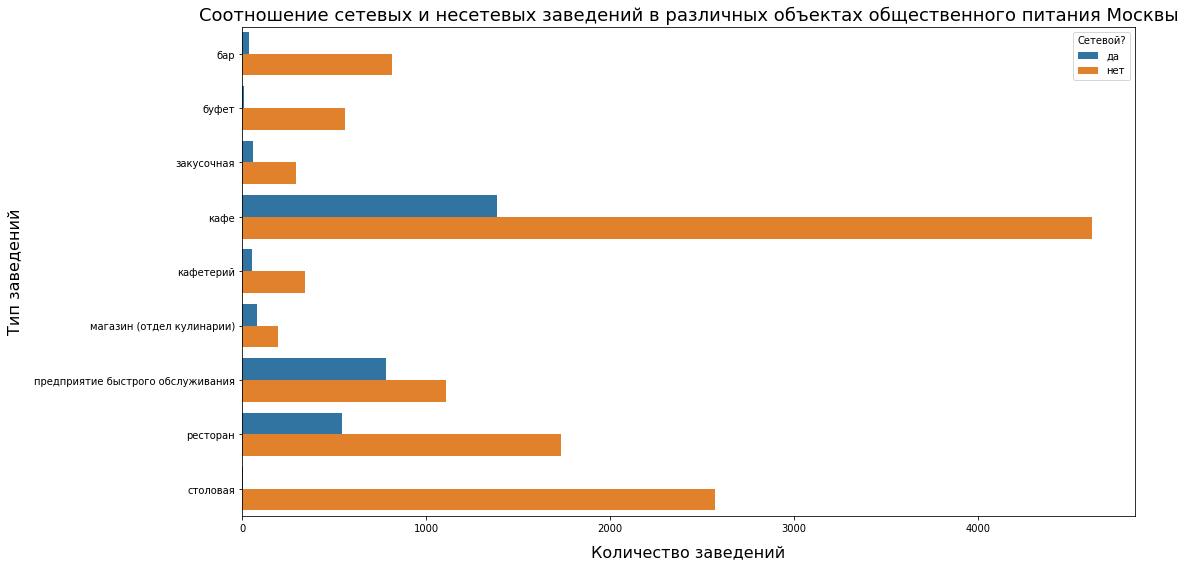

In [98]:
plt.figure(figsize=(16, 9))
sns.barplot(x='id', y='object_type', hue='chain', data=chain_type).set_title(
'Соотношение сетевых и несетевых заведений в различных объектах общественного питания \
Москвы', fontsize=18)
plt.ylabel('Тип заведений', fontsize=16, labelpad=12);
plt.xlabel('Количество заведений', fontsize=16, labelpad=12);
plt.legend(title='Сетевой?');

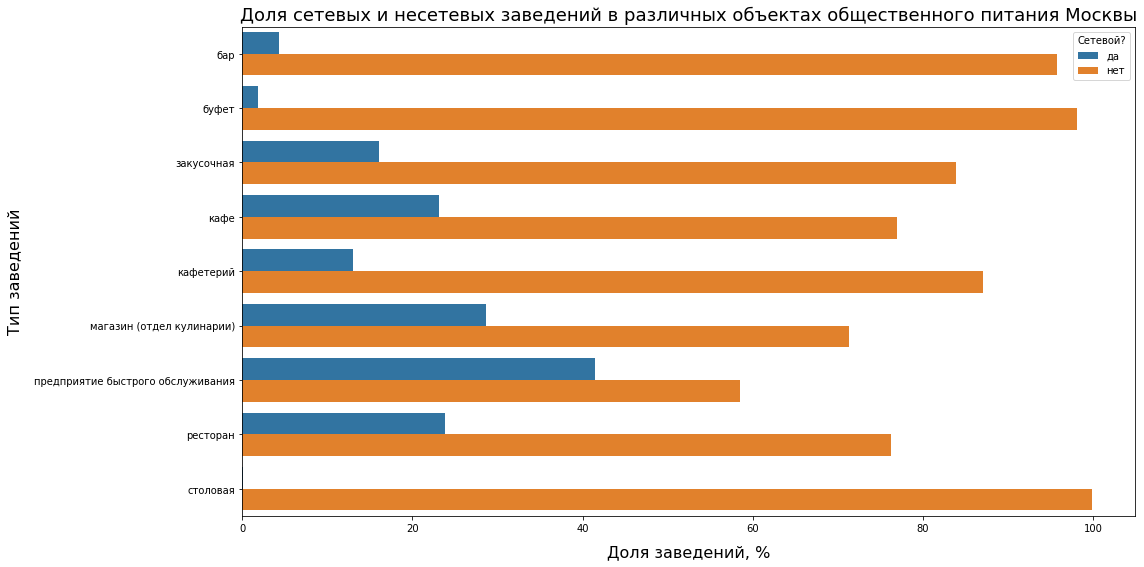

In [99]:
# Посмотрим на долю сетевой направленности по разным типам заведений
plt.figure(figsize=(16, 9))
sns.barplot(x='percent', y='object_type', hue='chain', data=chain_type).set_title(
'Доля сетевых и несетевых заведений в различных объектах общественного питания \
Москвы', fontsize=18)
plt.ylabel('Тип заведений', fontsize=16, labelpad=12);
plt.xlabel('Доля заведений, %', fontsize=16, labelpad=12);
plt.legend(title='Сетевой?');

**<font color="purple">Сетевое распростанение характерно преимущественно для объектов типа (в порядке убывания) "Кафе", "Предприятие быстрого обслуживания" (фастфуд) и "Ресторан". Практически отсутствует сетевая направленность столовых. У фастфудов преимущественно сетевая направленность, также почти половина всех отделов кулинарии - также имеет сетевой характер</font>**

#### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [100]:
#Вернемся к исходным данным
cafe.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


In [101]:
#Отфильтруем все сетевые заведения и сделаем группировку по количеству заведений каждой сети и медиан-
#ному значению количества посадочных мест
cafe_chain=cafe.query('chain=="да"').groupby('object_name').agg({'address':'count', 'number':'median'}).reset_index()
cafe_chain.head()

,object_name,address,number
0,beverly hills diner,1,88.0
1,bierloga,1,75.0
2,black & white,1,40.0
3,bocconcino,3,68.0
4,boobo,1,46.0


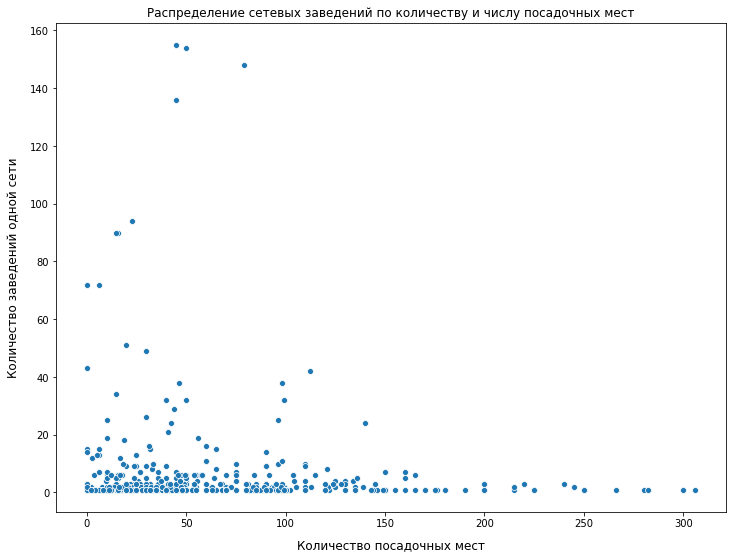

In [102]:
plt.figure(figsize=(12, 9)) 
sns.scatterplot(x="number", y="address", data=cafe_chain).set_title(
    'Распределение сетевых заведений по количеству и числу посадочных мест');
plt.xlabel('Количество посадочных мест', fontsize=12, labelpad=10);
plt.ylabel('Количество заведений одной сети', fontsize=12, labelpad=10);

In [103]:
cafe_chain.describe()

,address,number
count,576.000000,576.000000
mean,5.118056,58.034722
std,15.424880,53.730759
min,1.000000,0.000000
25%,1.000000,20.000000
50%,1.000000,43.500000
75%,3.000000,82.375000
max,155.000000,306.000000


**<font color="purple">Для 75% сетевых заведений общественного питания Москвы характерно количество посадочных мест до 80 и число заведений одной сети в пределах трех. Иными словами для сетевых заведений характерно малое количество точек одной сети, но достаточно большое количество посадочных мест в пределах каждой. </font>**

#### Среднее количество посадочных мест <a id="median_number"></a>

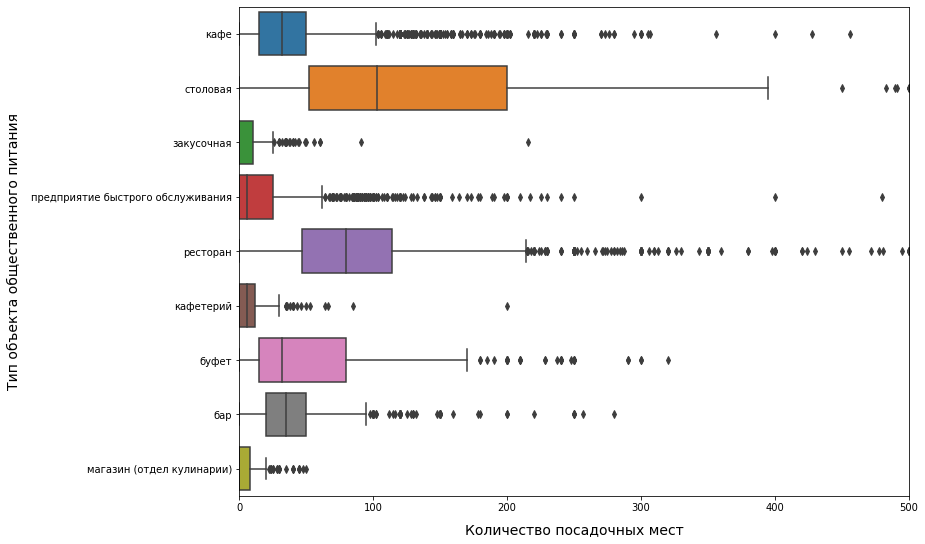

In [104]:
#Проверим параметр "Количество посадочных мест" на предмет выбросов
plt.figure(figsize=(12, 9)) 
sns.boxplot(x="number", y="object_type", data=cafe);
plt.ylabel('Тип объекта общественного питания', fontsize=14, labelpad=10);
plt.xlabel('Количество посадочных мест', fontsize=14, labelpad=10);
plt.xlim(0, 500);

In [105]:
cafe.groupby('object_type')['number'].describe()


,count,mean,std,min,25%,50%,75%,max
object_type,,,,,,,,
бар,853.0,43.602579,67.175723,0.0,20.0,35.0,50.0,1700.0
буфет,570.0,51.487719,56.537193,0.0,15.0,32.0,80.0,320.0
закусочная,347.0,7.685879,16.636435,0.0,0.0,0.0,10.0,216.0
кафе,6008.0,39.886984,37.801322,0.0,15.0,32.0,50.0,533.0
кафетерий,393.0,9.221374,14.704725,0.0,0.0,6.0,12.0,200.0
магазин (отдел кулинарии),272.0,5.610294,9.885076,0.0,0.0,0.0,8.0,50.0
предприятие быстрого обслуживания,1890.0,20.787302,38.575910,0.0,0.0,6.0,25.0,580.0
ресторан,2274.0,97.065963,94.891297,0.0,47.0,80.0,114.0,1500.0
столовая,2575.0,130.367767,95.279805,0.0,52.0,103.0,200.0,1400.0


**<font color="purple">В наших данных много выбросов, искажающих среднее значение. В расчетах мы будем использовать медиану </font>**

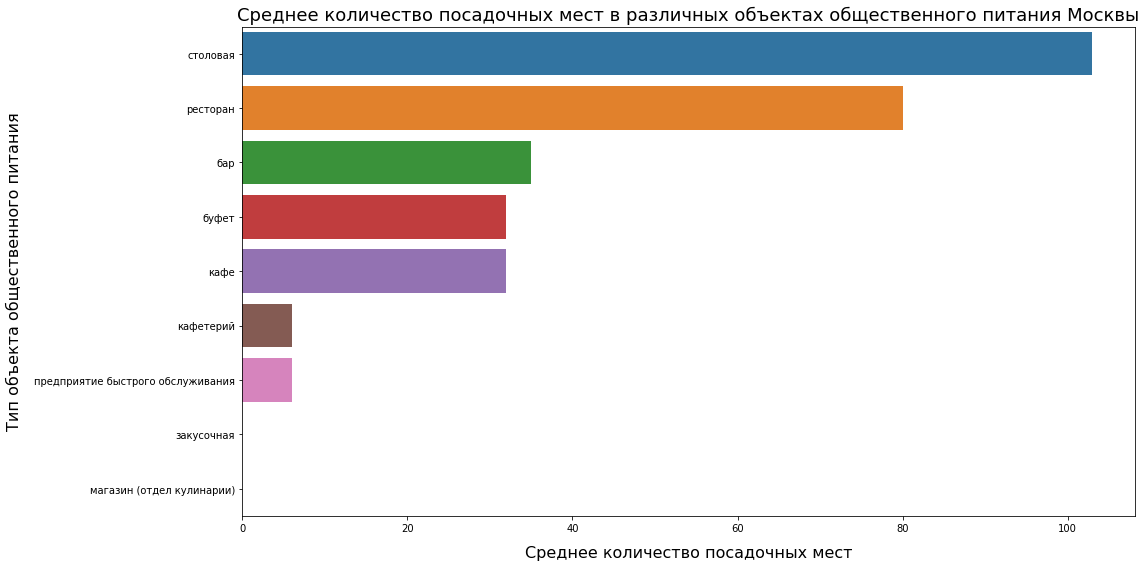

In [106]:
median_number=cafe.groupby('object_type').agg({'number':'median'}).reset_index().sort_values(
    by='number', ascending=False)
plt.figure(figsize=(16, 9))
sns.barplot(x='number', y='object_type', data=median_number).set_title(
'Среднее количество посадочных мест в различных объектах общественного питания Москвы', fontsize=18)
plt.ylabel('Тип объекта общественного питания', fontsize=16, labelpad=12);
plt.xlabel('Среднее количество посадочных мест', fontsize=16, labelpad=12);


**<font color="purple">Самое большое количество посадочных мест наблюдается в столовых. Интересно, что в закусочных и отделах кулинарии посадочных мест нет вовсе.</font>**

#### Выделение в отдельный столбец информации об улице <a id="street"></a>

In [107]:
# Из столбца с адресом извлечем название улицы
cafe['street']=cafe['address'].str.extract(r'(?<=москва,)([^,]+)')
cafe.head()

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица


In [108]:
cafe.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15182 entries, 0 to 15364
Data columns (total 7 columns):
id             15182 non-null int64
object_name    15182 non-null object
chain          15182 non-null object
object_type    15182 non-null object
address        15182 non-null object
number         15182 non-null int64
street         15111 non-null object
dtypes: int64(2), object(5)
memory usage: 1.6+ MB


Некоторые строки с названием улицы не заполнились, посмотрим почему

In [109]:
cafe[cafe['street'].isnull()].head()

,id,object_name,chain,object_type,address,number,street
859,23601,буфет - гбоу сош № 64,нет,буфет,"партизанская улица, дом 30",100,NaN
860,23604,буфет - гбоу 60,нет,буфет,"партизанская улица, дом 30",100,NaN
1491,25349,ресторан «гранатовый сад»,нет,ресторан,"поречная улица, дом 5/14, строение 1",40,NaN
7691,132359,кафе «la carotte»,нет,кафе,"1-й нагатинский проезд, дом 10",198,NaN
7827,28214,роснефть (закрытое),нет,столовая,"софийская набережная, дом 26/1, строение 1",80,NaN


Пропуски образовались, потому что не сработала экстракция по регулярному выражению из-за отсутствия связки "Москва,". Заполним эти пропуски, принимая, что все адреса, где пропущено название - город Москва, относятся к Москве. 

In [110]:
#Сначала создадим еще один столбец, куда извлечем названия улиц из столбца с адресом, 
#где не указана Москва
cafe['street2'] = cafe['address'].str.split(',',expand=True)[0]
cafe.head()

,id,object_name,chain,object_type,address,number,street,street2
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова,город москва
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина,город москва
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица,город москва
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица,город москва
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица,город москва


In [111]:
#Заполним пропуски
cafe['street'] = cafe['street'].fillna(cafe['street2'])

In [112]:
#Проверим на одной строке
cafe.query('id==28214')

,id,object_name,chain,object_type,address,number,street,street2
7827,28214,роснефть (закрытое),нет,столовая,"софийская набережная, дом 26/1, строение 1",80,софийская набережная,софийская набережная


In [113]:
#Удалим вспомогательный столбец ['street2'] и проверим еще раз весь датафрейм
cafe = cafe.drop(['street2'], axis = 1)
cafe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15182 entries, 0 to 15364
Data columns (total 7 columns):
id             15182 non-null int64
object_name    15182 non-null object
chain          15182 non-null object
object_type    15182 non-null object
address        15182 non-null object
number         15182 non-null int64
street         15182 non-null object
dtypes: int64(2), object(5)
memory usage: 1.6+ MB


In [114]:
#Удалим пробелы в столбце Street, если таковые имеются
#cafe['street'] = cafe['street'].map(str.strip)

#### Топ-10 улиц по количеству объектов общественного питания <a id="top10"></a>

Выделим топ 10 улиц с максимальным количеством объектов общественного питания

In [115]:
#Сгруппируем исходную таблицу cafe по названию улицы и подсчитаем число заведений в каждой, 
#отсортируем по убыванию, удалим дубликаты
cafe_total = cafe.groupby('street').agg({'id':'count'})
cafe_total = cafe_total.reset_index().rename(columns={'id':'count'})
cafe_total['street'] = cafe_total['street'].map(str.strip)
cafe_total = cafe_total.sort_values(by='count', ascending=False).drop_duplicates()
cafe_total.tail()

,street,count
877,новолучанская улица,1
881,новоостаповская улица,1
886,новопресненский переулок,1
890,новорублёвская улица,1
1902,школьная улица,1


In [116]:
#Выделим улицы с максимальным количеством общепитов

top10=cafe_total.head(12).reset_index(drop=True)
top10

,street,count
0,город зеленоград,230
1,проспект мира,196
2,профсоюзная улица,180
3,ленинградский проспект,170
4,пресненская набережная,165
5,варшавское шоссе,159
6,ленинский проспект,147
7,поселение сосенское,137
8,проспект вернадского,126
9,кутузовский проспект,114


In [117]:
#Удалим Зеленоград и Поселение Сосновское, поскольку они не являются улицами
top10=top10.query('street not in ("город зеленоград", "поселение сосенское")').reset_index(drop=True)
top10

,street,count
0,проспект мира,196
1,профсоюзная улица,180
2,ленинградский проспект,170
3,пресненская набережная,165
4,варшавское шоссе,159
5,ленинский проспект,147
6,проспект вернадского,126
7,кутузовский проспект,114
8,каширское шоссе,110
9,кировоградская улица,107


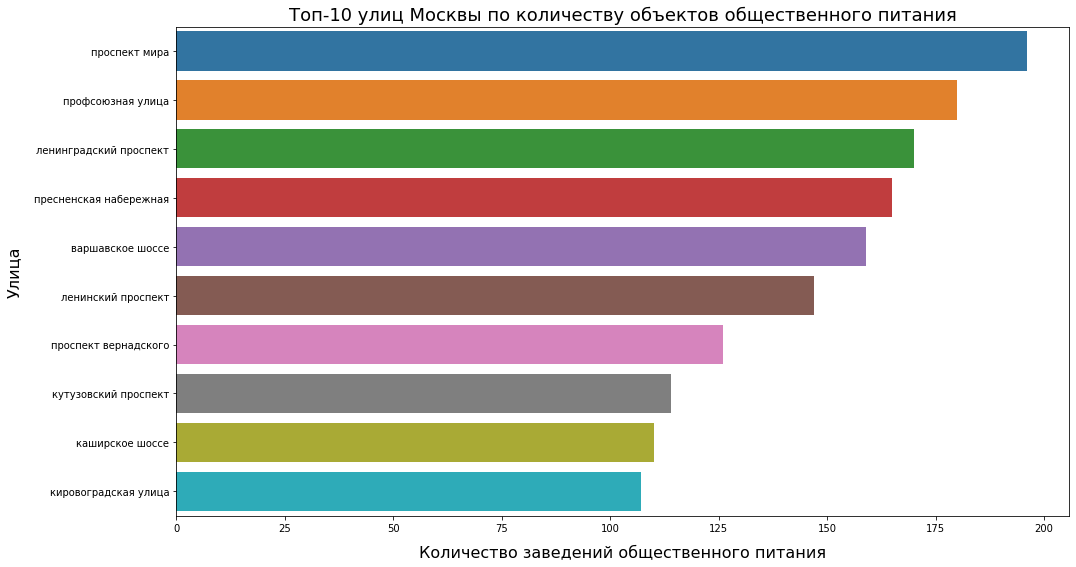

In [118]:
#Визуализируем наши данные
plt.figure(figsize=(16, 9))
sns.barplot(x='count', y='street', data=top10).set_title(
'Топ-10 улиц Москвы по количеству объектов общественного питания', fontsize=18)
plt.ylabel('Улица', fontsize=16, labelpad=12);
plt.xlabel('Количество заведений общественного питания', fontsize=16, labelpad=12);

In [119]:
#Импортируем общемосковский классификатор улиц Москвы

spreadsheet_id = '1oaxWZjI-TIDh6z7VIkrD1oRZgZvI34y-HaqU5FT3Gd4'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
moscow_streets = pd.read_csv(BytesIO(r.content))
moscow_streets.head()

,UM_CODE,UM_NAMEF,global_id,UM_NAMES,UM_TRANS,UM_TYPE,UM_TM,UM_TE,UM_KLADR
0,008880,1-й Ирининский переулок,58481065,1-й Ирининский пер.,Pervy'j Irininskij pereulok,002,NaN,0102,77000000000706300
1,008890,2-й Ирининский переулок,58481066,2-й Ирининский пер.,Vtoroj Irininskij pereulok,002,NaN,0102,77000000000362200
2,008891,3-й Ирининский переулок,58481067,3-й Ирининский пер.,Tretij Irininskij pereulok,002,NaN,0102,77000000000362300
3,008910,Иркутская улица,58481068,Иркутская ул.,Irkutskaya ulicza,001,NaN,0406,77000000000139700
4,008920,1-й Иртышский проезд,58481069,1-й Иртышский пр.,Pervy'j Irty'shskij proezd,003,NaN,0406,77000000000331600


In [120]:
#Оставим в этой таблице только названия улиц и код/коды районов, которым они принадлежат, удалим
#пробелы, если таковые имеются, удалим дубликаты
moscow_streets=moscow_streets[['global_id', 'UM_NAMEF', 'UM_TE']]
moscow_streets = moscow_streets.rename(columns={'UM_NAMEF': 'street', 'UM_TE':'kod'})
moscow_streets['street']=moscow_streets['street'].map(str.strip).str.lower()
moscow_streets.drop_duplicates().head()

,global_id,street,kod
0,58481065,1-й ирининский переулок,0102
1,58481066,2-й ирининский переулок,0102
2,58481067,3-й ирининский переулок,0102
3,58481068,иркутская улица,0406
4,58481069,1-й иртышский проезд,0406


In [121]:
moscow_streets['global_id'].nunique()

5236

In [122]:
#Объединим таблицy из внешнего источника, где есть коды районов с нашей сгруппированной по топ улицам 
#таблицей
top_10 = top10.merge(moscow_streets, on='street').drop_duplicates()

top_10

,street,count,global_id,kod
0,проспект мира,196,58481760,0105;0301;0309;0310;0312;0313;0317
1,профсоюзная улица,180,58482469,0701;0704;0707;0709;0710;0712
2,ленинградский проспект,170,58481514,0201;0202;0214;0217
3,пресненская набережная,165,58482416,0106
4,варшавское шоссе,159,58485474,0610;0613;0615;0619;0620;0621;0708;0711;1111
5,ленинский проспект,147,58481520,0110;0610;0702;0706;0707;0709;0814;0817
6,проспект вернадского,126,58485499,0702;0706;0814;0815;0817
7,кутузовский проспект,114,58481479,0805;0819
8,каширское шоссе,110,58481166,0612;0613;0616;0617
9,кировоградская улица,107,58481183,0619;0620;0621


In [123]:
#Одна улица может проходить через несколько районов. Выделим коды районов в отдельные ячейки
codes = top_10['kod'].str.split(';', expand = True)
codes.tail()

,0,1,2,3,4,5,6,7,8
5,0110,0610,0702,0706,0707,0709,0814,0817,None
6,0702,0706,0814,0815,0817,None,None,None,None
7,0805,0819,None,None,None,None,None,None,None
8,0612,0613,0616,0617,None,None,None,None,None
9,0619,0620,0621,None,None,None,None,None,None


In [124]:
#Конкатенируем все столбцы предыдущей таблицы в один, удалим пропуски, преобразуем в датафрейм
#и изменим тип данных на int
codes = pd.concat([codes[0], codes[1], codes[2], codes[3], codes[4], codes[5], codes[6],
                   codes[7], codes[8]])
codes = codes.dropna()
codes = codes.to_frame(name='code')
codes['code'] = codes['code'].astype('int')


codes.head()

,code
0,105
1,701
2,201
3,106
4,610


In [125]:
#Объединим таблицы codes и top10 по индексу
top_10 = codes.join(top_10)
top_10

,code,street,count,global_id,kod
0,105,проспект мира,196,58481760,0105;0301;0309;0310;0312;0313;0317
0,301,проспект мира,196,58481760,0105;0301;0309;0310;0312;0313;0317
0,309,проспект мира,196,58481760,0105;0301;0309;0310;0312;0313;0317
0,310,проспект мира,196,58481760,0105;0301;0309;0310;0312;0313;0317
0,312,проспект мира,196,58481760,0105;0301;0309;0310;0312;0313;0317
0,313,проспект мира,196,58481760,0105;0301;0309;0310;0312;0313;0317
0,317,проспект мира,196,58481760,0105;0301;0309;0310;0312;0313;0317
1,701,профсоюзная улица,180,58482469,0701;0704;0707;0709;0710;0712
1,704,профсоюзная улица,180,58482469,0701;0704;0707;0709;0710;0712
1,707,профсоюзная улица,180,58482469,0701;0704;0707;0709;0710;0712


In [126]:
#Подгрузим данные о районах Москвы
spreadsheet_id = '1KEGudmKPWC6Mi1aZRY2n4vOOhaiuI6N5HLapCV9D364'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
moscow_districts = pd.read_csv(BytesIO(r.content))
moscow_districts.head()

,Kod,Name,global_id,Latin_name,Type,Kod_okato
0,100,Центральный административный округ,58703558,Czentral`ny'j administrativny'j okrug,2,45286000
1,101,район Арбат,58703559,rajon Arbat,3,45286552
2,102,Басманный район,58703560,Basmanny'j rajon,3,45286555
3,103,район Замоскворечье,58703561,rajon Zamoskvorech`e,3,45286560
4,104,Красносельский район,58703562,Krasnosel`skij rajon,3,45286565


In [127]:
#Немного отформатируем наши данные: переведем в нижний регистр данные столбца с названием улицы и
#названия столбцов.
moscow_districts['Name'] = moscow_districts['Name'].str.lower()
moscow_districts.columns = map(str.lower, moscow_districts.columns)
moscow_districts = moscow_districts[['kod', 'name']]
moscow_districts.head()

,kod,name
0,100,центральный административный округ
1,101,район арбат
2,102,басманный район
3,103,район замоскворечье
4,104,красносельский район


In [128]:
#Объединим таблицу с районами и таблицу с нашими топ улицами и удалим лишнюю информацию из таблицы
top_10 = top_10.merge(moscow_districts, left_on='code', right_on='kod')
top_10 = top_10.drop(['kod_x', 'kod_y'], axis = 1)
top_10 = top_10.sort_values(by='count', ascending=False)
top_10.head()

,code,street,count,global_id,name
0,105,проспект мира,196,58481760,мещанский район
2,309,проспект мира,196,58481760,район марьина роща
3,310,проспект мира,196,58481760,останкинский район
4,312,проспект мира,196,58481760,район ростокино
5,313,проспект мира,196,58481760,район свиблово


In [129]:
#Посмотрим сколько всего районов охватывают наши Топ 10 улиц
top_10['code'].nunique()

38

In [130]:
# Сколько всего районов в Москве
moscow_districts['kod'].nunique()

158

In [131]:
#Сгруппируем таблицу для ясности картины
pd.set_option('display.max_colwidth', 200)
top_10 = top_10.pivot_table(index=['street', 'count'], values = 'name', aggfunc=(
    'count', 'unique'))
top_10.columns = ['districts', 'unique' ]
top_10.sort_values(by='districts', ascending=False)

,,districts,unique
street,count,,
варшавское шоссе,159,9,"[район чертаново южное, район чертаново центральное, район южное бутово, район северное бутово, поселение щербинка, район чертаново северное, нагорный район, район нагатино-садовники, донской район]"
ленинский проспект,147,8,"[ломоносовский район, обручевский район, район тропарёво-никулино, район проспект вернадского, гагаринский район, район якиманка, район тёплый стан, донской район]"
проспект мира,196,7,"[мещанский район, район марьина роща, останкинский район, район ростокино, район свиблово, ярославский район, алексеевский район]"
профсоюзная улица,180,6,"[район тёплый стан, район ясенево, район черёмушки, район коньково, обручевский район, академический район]"
проспект вернадского,126,5,"[гагаринский район, ломоносовский район, район проспект вернадского, район тропарёво-никулино, район раменки]"
каширское шоссе,110,4,"[район москворечье-сабурово, район орехово-борисово северное, район нагатино-садовники, район орехово-борисово южное]"
ленинградский проспект,170,4,"[хорошёвский район, район сокол, район аэропорт, район беговой]"
кировоградская улица,107,3,"[район чертаново северное, район чертаново южное, район чертаново центральное]"
кутузовский проспект,114,2,"[район дорогомилово, район фили-давыдково]"


**<font color="purple">Мы выделили Топ 10 улиц Москвы с максимальным количеством заведений общественного питания. Выяснили, что это - большие улицы, проспекты, шоссе, которые проходят преимущественно через несколько  районов. Исключение составляет Пресненская набережная с высокой концентрацией заведений в пределах одного Пресненского района. Всего в Москве 158 районов. 38 из них (или 24%) пересекают крупные улицы, которые мы выделили как топ 10 по количеству заведений общественного питания. </font>**

#### Число улиц с одним объектом общественного питания <a id="only_one"></a>

In [132]:
#сфомируем таблицу по условию: одно заведение на одной улице
only_one = cafe_total.query('count==1').reset_index(drop=True)
only_one['street'].nunique()

580

In [133]:
#ОБъединим таблицы с данными по ресторанам и внешними данными с улицами и кодами районов
only_one=only_one.merge(moscow_streets, on='street')
only_one['street'].nunique()

569

In [134]:
only_one.drop_duplicates().reset_index(drop=True)

,street,count,global_id,kod
0,дербеневская улица,1,58485825,0609
1,большая серпуховская улица,1,58482770,0103;0609
2,проезд добролюбова,1,58485858,0305
3,профсоюзная улица,1,58482469,0701;0704;0707;0709;0710;0712
4,улица обручева,1,58482079,0704;0707;0710
...,...,...,...,...
652,школьная улица,1,58484299,1207
653,школьная улица,1,58484488,1210
654,школьная улица,1,58484586,1111
655,школьная улица,1,58484663,1209


In [135]:
#В данном датафрейме также есть улицы, которые пересекают несколько районов. Выделим коды в отдельные
#ячейки и конкатенируем их в один столбец
codes_2 = only_one['kod'].str.split(';', expand = True)
codes_2.head(5)

,0,1,2,3,4,5,6,7,8
0,0609,None,None,None,None,None,None,None,None
1,0103,0609,None,None,None,None,None,None,None
2,0305,None,None,None,None,None,None,None,None
3,0701,0704,0707,0709,0710,0712,None,None,None
4,0704,0707,0710,None,None,None,None,None,None


In [136]:
#Сделаем конкатенацию
codes_2 = pd.concat([codes_2[0], codes_2[1], 
                     codes_2[2], codes_2[3], codes_2[4], codes_2[5], codes_2[6], codes_2[7], 
                     codes_2[8]])
codes_2 = codes_2.dropna()
codes_2 = codes_2.to_frame(name='code')
codes_2['code'] = codes_2['code'].astype('int')


codes_2.shape

(741, 1)

In [137]:
#Объединим таблицы codes и only_one по индексу и сохраним индекс как новый столбец: одинаковый индекс
#означает, что улица проходит через несколько районов. Но бывает и так, что улица с одним названием 
#есть в нескольких районах. В этом случае индекс этой улицы будет другой.
only_one = codes_2.join(only_one).reset_index()
only_one.head(15)

,index,code,street,count,global_id,kod
0,0,609,дербеневская улица,1,58485825,0609
1,1,103,большая серпуховская улица,1,58482770,0103;0609
2,1,609,большая серпуховская улица,1,58482770,0103;0609
3,2,305,проезд добролюбова,1,58485858,0305
4,3,701,профсоюзная улица,1,58482469,0701;0704;0707;0709;0710;0712
5,3,704,профсоюзная улица,1,58482469,0701;0704;0707;0709;0710;0712
6,3,707,профсоюзная улица,1,58482469,0701;0704;0707;0709;0710;0712
7,3,709,профсоюзная улица,1,58482469,0701;0704;0707;0709;0710;0712
8,3,710,профсоюзная улица,1,58482469,0701;0704;0707;0709;0710;0712
9,3,712,профсоюзная улица,1,58482469,0701;0704;0707;0709;0710;0712


In [138]:
# Найдем общее количество районов, которые пересекают улицы с одним заведением
only_one['code'].nunique()

129

In [139]:
#Вспомним общее количество районов Москвы
moscow_districts['kod'].nunique()

158

In [140]:
#Объединим таблицу с районами и таблицу с нашими улицами, где только 1 заведение и удалим лишнюю 
#информацию из таблицы
only_one = only_one.merge(moscow_districts, left_on='code', right_on='kod')
only_one = only_one.drop(['kod_x', 'kod_y'], axis = 1)
only_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 741 entries, 0 to 740
Data columns (total 6 columns):
index        741 non-null int64
code         741 non-null int64
street       741 non-null object
count        741 non-null int64
global_id    741 non-null object
name         741 non-null object
dtypes: int64(3), object(3)
memory usage: 40.5+ KB


То есть у нас всего 741 улица с одним заведением

In [141]:
only_one.head()

,index,code,street,count,global_id,name
0,0,609,дербеневская улица,1,58485825,даниловский район
1,1,609,большая серпуховская улица,1,58482770,даниловский район
2,9,609,улица павла андреева,1,58485218,даниловский район
3,76,609,хавская улица,1,58483280,даниловский район
4,152,609,улица сайкина,1,58482678,даниловский район


In [142]:
# Напомним, сколько всего улиц в Москве
moscow_streets['global_id'].nunique()

5236

In [143]:
#Сгруппируем таблицу для ясности картины по индексу
pd.set_option('display.max_colwidth', 200)
one_cafe = only_one.pivot_table(index=['index', 'street'], values = 'name', aggfunc=(
    'count', 'unique'))
one_cafe.columns = ['districts', 'unique' ]
one_cafe.sort_values(by='districts', ascending=False).head(15)

,,districts,unique
index,street,,
12,варшавское шоссе,9,"[район чертаново северное, район чертаново центральное, район чертаново южное, донской район, район нагатино-садовники, нагорный район, район северное бутово, район южное бутово, поселение щербинка]"
68,ленинский проспект,8,"[обручевский район, район тёплый стан, донской район, район якиманка, гагаринский район, ломоносовский район, район проспект вернадского, район тропарёво-никулино]"
3,профсоюзная улица,6,"[академический район, район коньково, обручевский район, район тёплый стан, район черёмушки, район ясенево]"
71,алтуфьевское шоссе,4,"[район лианозово, алтуфьевский район, район бибирево, район отрадное]"
625,нарвская улица,3,"[район коптево, войковский район, головинский район]"
294,11-я парковая улица,3,"[район северное измайлово, район измайлово, район восточное измайлово]"
11,чертановская улица,3,"[район чертаново северное, район чертаново центральное, район чертаново южное]"
479,улица достоевского,3,"[тверской район, мещанский район, район марьина роща]"
64,коровинское шоссе,3,"[бескудниковский район, дмитровский район, район западное дегунино]"


Мы видим, что в наш список попали улицы, которые входят в наш топ10 улиц. По-Видимому, где есть разница в написании названия улицы или пробел, который мы не учли. Посмотрим на датафрейм, из которого мы получали данные для таблицы one_cafe:

In [144]:
cafe_total.query('street=="варшавское шоссе"')

,street,count
416,варшавское шоссе,159
1857,варшавское шоссе,1


In [145]:
cafe_total.query('street=="ленинский проспект"')

,street,count
701,ленинский проспект,147
1868,ленинский проспект,1


In [146]:
cafe_total.query('street=="профсоюзная улица"')

,street,count
1076,профсоюзная улица,180
1884,профсоюзная улица,1


In [147]:
#Удалим эти три строчки в дата фрейме one_cafe, принимая их за погрешность
one_cafe = one_cafe.query('street!=("варшавское шоссе", "ленинский проспект", "профсоюзная улица")')
one_cafe.sort_values(by='districts', ascending=False).head(10)

,,districts,unique
index,street,,
71,алтуфьевское шоссе,4,"[район лианозово, алтуфьевский район, район бибирево, район отрадное]"
58,улица знаменка,3,"[тверской район, район арбат, район хамовники]"
11,чертановская улица,3,"[район чертаново северное, район чертаново центральное, район чертаново южное]"
64,коровинское шоссе,3,"[бескудниковский район, дмитровский район, район западное дегунино]"
479,улица достоевского,3,"[тверской район, мещанский район, район марьина роща]"
294,11-я парковая улица,3,"[район северное измайлово, район измайлово, район восточное измайлово]"
76,хавская улица,3,"[даниловский район, донской район, район якиманка]"
625,нарвская улица,3,"[район коптево, войковский район, головинский район]"
4,улица обручева,3,"[район коньково, обручевский район, район черёмушки]"


Найдем топ 10 районов, где больше всего улиц с одним заведением

In [148]:
only_one.head()

,index,code,street,count,global_id,name
0,0,609,дербеневская улица,1,58485825,даниловский район
1,1,609,большая серпуховская улица,1,58482770,даниловский район
2,9,609,улица павла андреева,1,58485218,даниловский район
3,76,609,хавская улица,1,58483280,даниловский район
4,152,609,улица сайкина,1,58482678,даниловский район


In [149]:
top10_districts = only_one.query(
    'street!=("варшавское шоссе", "ленинский проспект", "профсоюзная улица")').groupby('name').agg(
    {'street':'count'}).reset_index().sort_values(by='street', ascending=False).head(10)
top10_districts = top10_districts.reset_index(drop=True)
top10_districts

,name,street
0,таганский район,31
1,район хамовники,28
2,басманный район,26
3,тверской район,25
4,пресненский район,24
5,район арбат,19
6,район марьина роща,18
7,мещанский район,17
8,район сокольники,15
9,район замоскворечье,15


**<font color="purple"> Всего в Москве 158 районов, улицы с одним заведением находятся в 129 районах или 82% от общего числа районов. Общее количество улиц с одним заведением - 741, это 15% от общего числа улиц Москвы. Некоторые улицы, на которых всего лишь одно заведение общественного питания, пересекают несколько районов.Также мы выделили топ 10 районов, где  наибольшее количество улиц с одним заведением</font>**

#### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания <a id="seats"></a>

In [150]:
#Создадим таблицу с названием улицы и числом посадочных мест
seats = cafe.copy()
seats['street'] = seats['street'].map(str.strip)
seats = seats[['street', 'number']]
seats.head()

,street,number
0,улица егора абакумова,48
1,улица талалихина,35
2,абельмановская улица,95
3,абрамцевская улица,40
4,абрамцевская улица,50


In [151]:
#Отфильтруем наши топ10 улиц

top=top10['street'].map(str.strip)
seats=seats.loc[seats['street'].isin(top)].reset_index(drop=True)
seats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1479 entries, 0 to 1478
Data columns (total 2 columns):
street    1479 non-null object
number    1479 non-null int64
dtypes: int64(1), object(1)
memory usage: 23.2+ KB


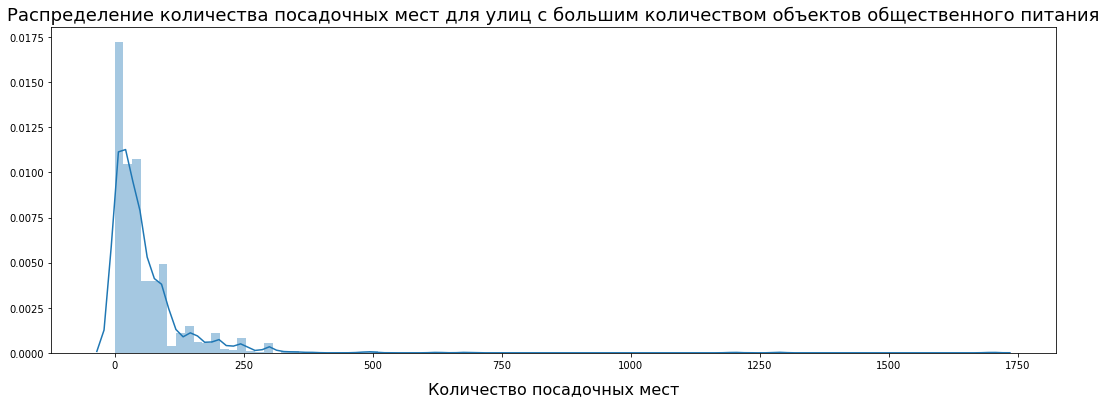

In [152]:
# Посмотрим на распределение
plt.figure(figsize=(18, 6))
sns.distplot(seats['number'], norm_hist=True, bins=100).set_title(
'Распределение количества посадочных мест для улиц с большим количеством объектов общественного \
питания', fontsize=18)
plt.xlabel('Количество посадочных мест', fontsize=16, labelpad=12);

In [153]:
seats.describe()

,number
count,1479.000000
mean,58.445571
std,90.590102
min,0.000000
25%,12.000000
50%,40.000000
75%,75.000000
max,1700.000000


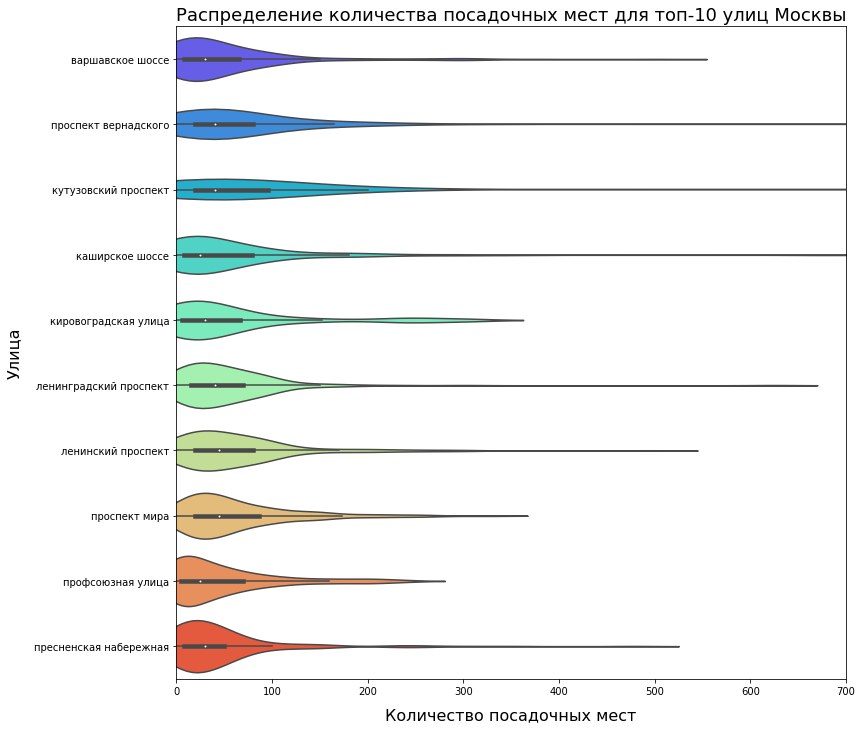

In [154]:
#Посмотрим на распределение по улицам
plt.figure(figsize=(12, 12))
sns.violinplot(x="number", y="street", data=seats, palette='rainbow').set_title(
'Распределение количества посадочных мест для топ-10 улиц Москвы', fontsize=18)
plt.ylabel('Улица', fontsize=16, labelpad=12);
plt.xlabel('Количество посадочных мест', fontsize=16, labelpad=12);
plt.xlim(0, 700);

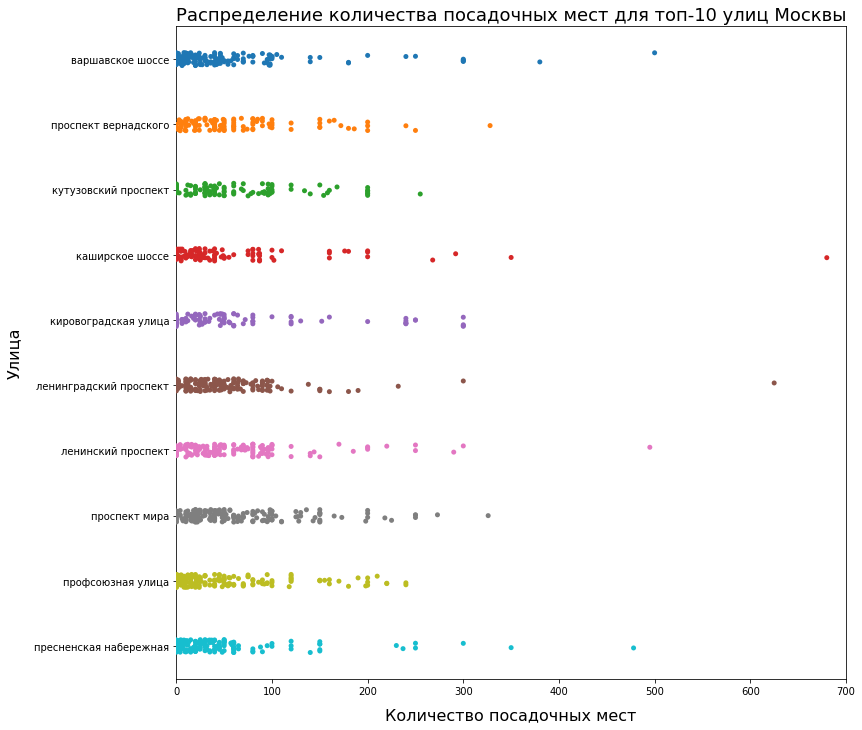

In [155]:
plt.figure(figsize=(12, 12))
sns.stripplot(x="number", y="street", data=seats).set_title(
'Распределение количества посадочных мест для топ-10 улиц Москвы', fontsize=18)
plt.ylabel('Улица', fontsize=16, labelpad=12);
plt.xlabel('Количество посадочных мест', fontsize=16, labelpad=12);
plt.xlim(0, 700);


**<font color="purple">В распределении количества посадочных мест по улицам наблюдаем множественные выбросы. Медианное количество посадочных мест - 40. При этом, ближе к центру, количество посадочных мест уменьшается, но увеличивается количество заведений в пределах улицы (проспект Мира). На Топ 10 улицах, продолжающих или примыкаюих к крупным автомагистралям, появляется все больше заведений с большим количеством посадочных мест по типу столовых. </font>**

### 5. Выводы <a id="summary"></a>
**<font color="purple"> В проекте мы исследовали рынок заведений общественного питания Москвы для оценки перспективы развития нашего кафе, особенностью которого является обслуживание роботами-официантами. Данные для исследования взяты из открытых источников: базу данных о заведениях Москвы предоставил Яндекс.Практикум, базу данных об улицах - районах Москвы взяли на портале открытых данных правительства Москвы от 09.08.2020: <https://data.mos.ru/classifier/2044>,<https://data.mos.ru/classifier/7710168515-obshchemoskovskiy-klassifikator-territorialnyh-edinits-moskvy-omk-002-2013-razdel-1> </font>**

**<font color="purple">В результате исследования получили следующие выводы:</font>**
1. Наибольшее количество заведений общественного питания Москвы относятся к категории "кафе" - их доля приближается к 40%. А 84% всех заведений представлены кафе, столовыми, ресторанами, предприятиями быстрого обслуживания (фастфуды).
2. 80% всего общепита представлена несетевыми заведениями. Сетевое распростанение характерно преимущественно для объектов типа (в порядке убывания) "Кафе", "Предприятие быстрого обслуживания" (фастфуд) и "Ресторан". Практически отсутствует сетевая направленность столовых.
4. Для 75% сетевых заведений общественного питания Москвы характерно количество посадочных мест до 80 и число заведений одной сети в пределах трех. Иными словами для сетевых заведений характерно малое количество точек одной сети, но достаточно большое количество посадочных мест в пределах каждой.
5. Самое большое количество посадочных мест наблюдается в столовых. В закусочных и отделах кулинарии посадочных мест нет вовсе.
6. Топ 10 улиц Москвы с максимальным количеством заведений общественного питания (в порядке убывания количества заведений): Проспект Мира, Профсоюзная улица, Ленинградский проспект, Пресненская набережная, Варшавское шоссе, Ленинский проспект, проспект Вернадского, Кутузовский проспект, Каширское шоссе, Кировоградская улица. Все эти улицы - протяженные, пересекают преимущественно несколько районов. Исключение составляет Пресненская набережная с высокой концентрацией заведений в пределах одного Пресненского района.  Находятся за пределами Садового кольца, с западной стороны Москвы от Севера к Югу (см. презентацию)
7. Улицы с одним заведением находятся в 129 районах или 82% от общего числа районов. Общее количество улиц с одним заведением - 741, это 15% от общего числа улиц Москвы. Некоторые улицы, на которых всего лишь одно заведение общественного питания, пересекают несколько районов. Также мы выделили топ 10 районов, где наибольшее количество улиц с 1 заведением. Эти районы - кандидаты для локализации нашего кафе.
8. В распределении количества посадочных мест по улицам наблюдаем множественные выбросы. Медианное количество посадочных мест - 40. При этом, ближе к центру, количество посадочных мест уменьшается, но увеличивается количество заведений в пределах улицы (проспект Мира). На Топ 10 улицах, продолжающих или примыкающих к крупным автомагистралям, появляется все больше заведений с большим количеством посадочных мест по типу столовых.


### 6. Рекомендации <a id="recommendation"></a>

**<font color="purple">Возможные ниши для нашего кафе видятся следующим образом:</font>**

**<font color="purple">1. Сетевое заведение по типу столовой, кафе, заведения быстрого обслуживания на больших улицах, примыкающих к автомагистралям с востока, юго-востока, северо-востока Москвы</font>**

**<font color="purple">2. Сетевое заведение на больших городских улицах, пересекающих несколько районов, с одним заведением на текущий момент. Для определения типа заведения необходимо дополнительное исследование районов и плотности заведений в их пределах.</font>**

**<font color="purple">3.Топ 10 районов с максимальным количеством улиц, где встречается лишь 1 заведение: Таганский район, район Хамовники, Басманный район, Тверской район, Пресненский район, район Арбат, район Марьина роща, Мещанский район, район Сокольники, район Замоскворечье</font>**

### 7 . Презентация <a id="presentation"></a>

Презентация: <https://drive.google.com/file/d/16RX1W-6jCIr9U_kqDkSXTMeOGUJs7igu/view?usp=sharing>